In [1]:
import os
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
segmentation_path = os.path.join(os.getcwd(), "..", "dataset", "binary-segmentation")
segmentations = os.listdir(segmentation_path)

In [3]:
def display(img):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap="gray")
    plt.show()

In [4]:
img = cv.imread(os.path.join(segmentation_path, segmentations[0]))
_, b_img = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
edges = cv.Canny(b_img, 100, 255)

In [5]:
top = []
bottom = []
img_width = img.shape[1]
img_height = img.shape[0]

for x in range(img_width):
    res = np.argwhere(edges[:, x] == 255)
    
    if res.shape[0] > 0:
        if res[0][0] > 350: # Exclude everything above y = 350
            top.append((x, res[0][0]))
        
        if res[-1][-1] > 350: # Exclude everything above y = 350
            bottom.append((x, res[-1][-1]))

top = np.array(top)
bottom = np.array(bottom)

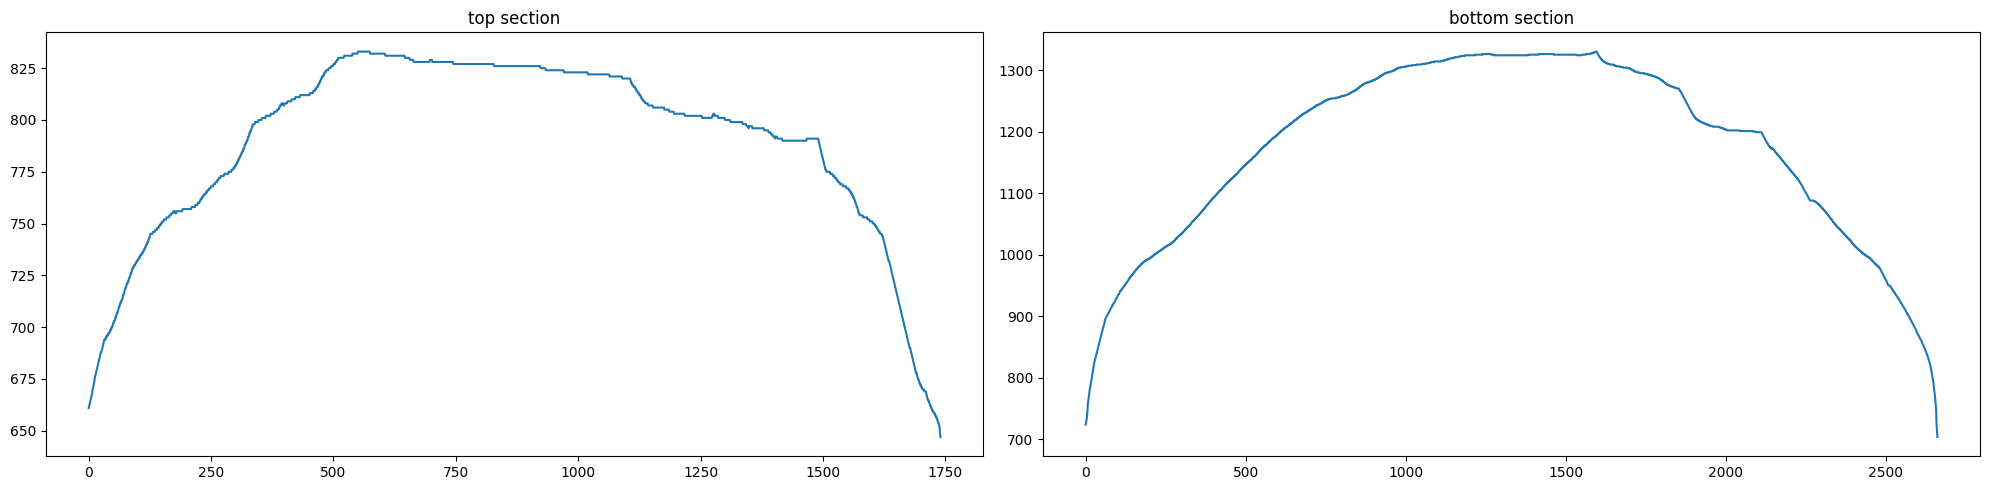

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(top.T[1])
axes[0].set_title("top section")
axes[1].plot(bottom.T[1])
axes[1].set_title("bottom section")

fig.tight_layout()

In [7]:
def get_angle(x1, x2, y1, y2):
    dx = x2 - x1
    dy = y2 - y1
    
    rad = math.atan2(dy, dx)
    
    return math.degrees(rad)

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    
    return int(math.ceil(qx)), int(math.ceil(qy))

In [8]:
RED = (255, 0, 0)
BLUE = (0, 0, 255)

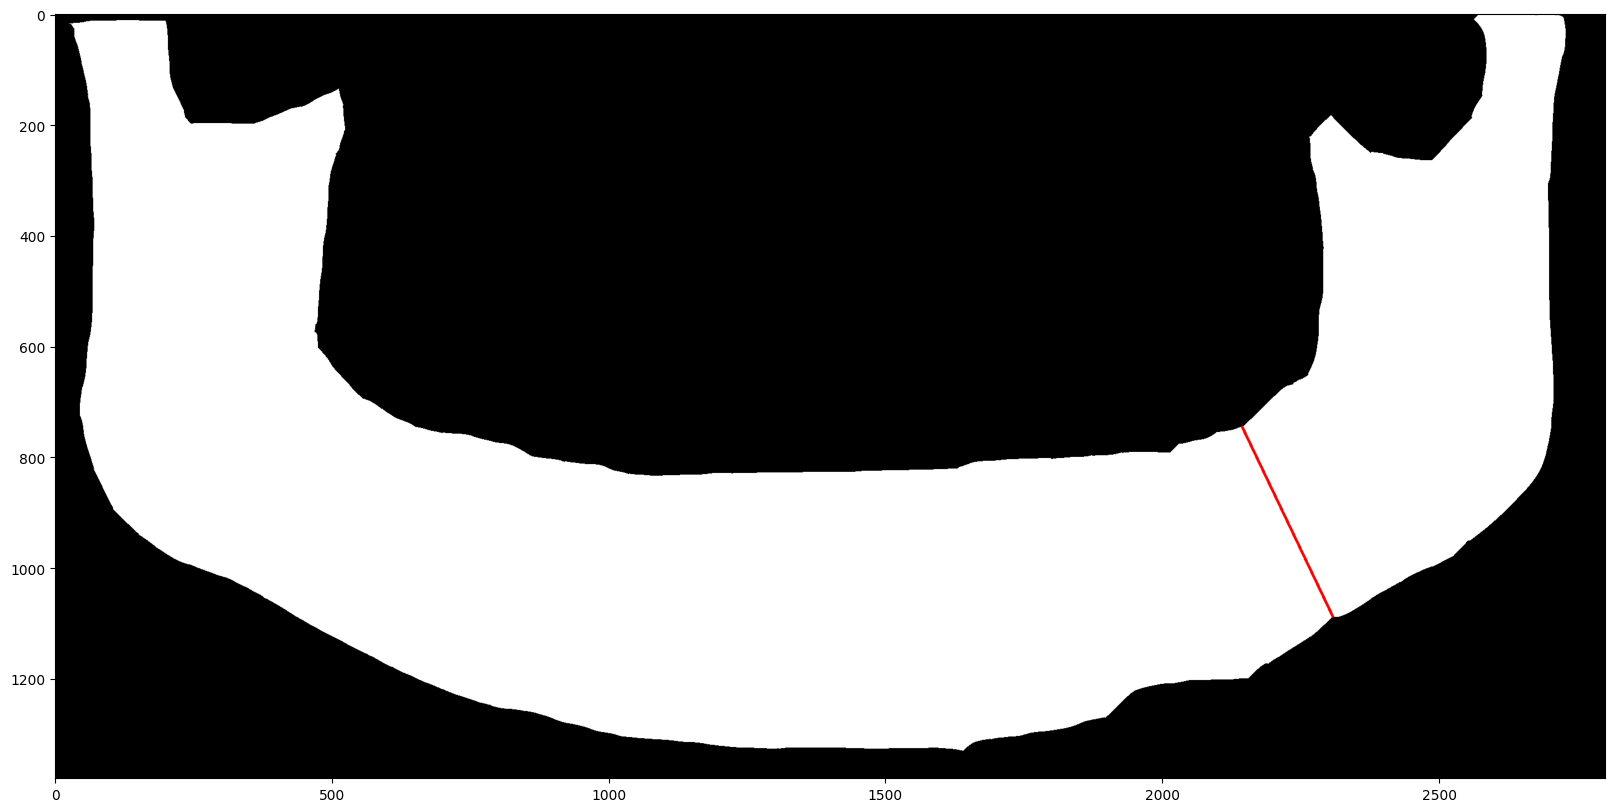

In [9]:
img1 = img.copy()
fbottom = interp1d(bottom.T[0], bottom.T[1], kind="cubic")
g_magnitudes = []
gtx, gty = [], []
gbx, gby = [], []

for i in range(0, len(top) - 4):
    x1, y1 = top[i]
    x2, y2 = top[i + 3]
    
    origin = x1, y1
    point = x2, y2
    
    rotated_point = rotate_point(origin, point, math.radians(90))
    rx, ry = rotated_point
    
    dx = x2 - x1
    dy = y2 - y1 
    
    magnitude = math.sqrt((dx ** 2) + (dy ** 2))
    uv_x, uv_y = dx / magnitude, dy / magnitude # unit vector
    
    magnitudes = []
    bxs, bys = [], []
    
    for bx, by in bottom:
        ldx, ldy = max(bx, x1) - min(bx, x1), max(by, y1) - min(by, y1)
        l_magnitude = math.sqrt((ldx ** 2) + (ldy ** 2))
        magnitudes.append(l_magnitude)
        bxs.append(bx)
        bys.append(by)
        
    rbx, rby = rotate_point(origin, (x1 + (uv_x * min(magnitudes)),  y1 + (uv_y * min(magnitudes))), math.radians(90))
    
    idx = magnitudes.index(min(magnitudes))
    g_magnitudes.append(min(magnitudes))
    gtx.append(x1)
    gty.append(y1)
    gbx.append(bxs[idx])
    gby.append(bys[idx])
    t_angle = get_angle(x1, x2, y1, y2)
    

i = g_magnitudes.index(min(g_magnitudes))
cv.line(img1, (gtx[i], gty[i]), (gbx[i], gby[i]), (250, 0, 0), 3)
    
display(img1)